# Planck Covmat vs CosmicFish Noise Diagnostics

This notebook compares Legacy and Knox CMB-noise runs against Planck chain products without rerunning long Fishers.

It loads:
- `legacy_full` (CFP legacy noise)
- `knox_full` (CFP knox noise)
- `knox_3part = high(30..2508, T+E) + lowTT(2..29) + lowEE(2..29)`

For Planck covmat, it builds two references:
- **marginalized reference**: invert cosmology covariance block `C_cc^{-1}`
- **conditional reference** (nuisance fixed): invert full covmat to `F`, then take `F_cc`

Before running this notebook, generate the required Fisher products with `uv run bash scripts/run_planck_diagnostics_suite.sh`.
If Planck chain products are missing locally, download them from https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Cosmological_Parameters and place them under `Planck-Results/` in the expected directory structure.

No long Fisher computation is run in this notebook.

In [14]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from cosmicfishpie.analysis import fisher_matrix as fm_mod
import cosmicfishpie.analysis.fishconsumer as fco


def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "cosmicfishpie").exists() and (p / "Planck-Results").exists():
            return p
    raise RuntimeError("Could not find repo root containing 'cosmicfishpie/' and 'Planck-Results/'")


repo_root = find_repo_root(Path.cwd())
params = ["ombh2", "omch2", "theta", "tau", "logAs", "ns"]

print("Repo root:", repo_root)

Repo root: /home/casas/Cosmo/cosmicfishpie


In [15]:
paths = {
    "legacy_full": repo_root / "tmp/planck_bestfit_theta/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt",
    "knox_full": repo_root / "tmp/planck_bestfit_theta_knox_full/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt",
    "knox_full_l1500": repo_root / "tmp/planck_bestfit_theta_knox_full_l1500/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt",
    "knox_high": repo_root / "tmp/planck_bestfit_theta_knox_3part/high_te/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt",
    "knox_low_t": repo_root / "tmp/planck_bestfit_theta_knox_3part/low_t/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_T_FM.txt",
    "knox_low_e": repo_root / "tmp/planck_bestfit_theta_knox_3part/low_e/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_E_FM.txt",
    "planck_dir": repo_root / "Planck-Results/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_R3.00/base/plikHM_TTTEEE_lowl_lowE",
}

for key, val in paths.items():
    print(f"{key:>12}: {val}")

required = ["legacy_full", "knox_full", "knox_full_l1500", "knox_high", "knox_low_t", "knox_low_e", "planck_dir"]
missing = [k for k in required if not paths[k].exists()]
if missing:
    raise FileNotFoundError(
        "Missing required inputs. Run `uv run bash scripts/run_planck_diagnostics_suite.sh` first for: "
        + ", ".join(missing)
    )

 legacy_full: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt
   knox_full: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_full/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt
knox_full_l1500: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_full_l1500/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt
   knox_high: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_3part/high_te/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_TCMB_E_FM.txt
  knox_low_t: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_3part/low_t/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_T_FM.txt
  knox_low_e: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_3part/low_e/CosmicFish_v1.3.0_planck_bestfit_theta_primary__CMB_E_FM.txt
  planck_dir: /home/casas/Cosmo/cosmicfishpie/Planck-Results/COM_CosmoParams_base-plikHM-TTTEEE-lowl-lowE_

In [16]:
f_legacy = fm_mod.fisher_matrix(file_name=str(paths["legacy_full"]))
f_knox_full = fm_mod.fisher_matrix(file_name=str(paths["knox_full"]))
f_knox_full_l1500 = fm_mod.fisher_matrix(file_name=str(paths["knox_full_l1500"]))
f_knox_high = fm_mod.fisher_matrix(file_name=str(paths["knox_high"]))
f_knox_low_t = fm_mod.fisher_matrix(file_name=str(paths["knox_low_t"]))
f_knox_low_e = fm_mod.fisher_matrix(file_name=str(paths["knox_low_e"]))

f_knox_3part = f_knox_high + f_knox_low_t + f_knox_low_e
f_knox_3part.name = "CosmicFish_v1.3.0_planck_bestfit_theta_knox_3part_FM"

out_threepart = repo_root / "tmp/planck_bestfit_theta_knox_3part/combined"
out_threepart.mkdir(parents=True, exist_ok=True)
out_threepart_root = out_threepart / f_knox_3part.name
f_knox_3part.save_to_file(str(out_threepart_root))

print("Saved combined 3-part Fisher:", str(out_threepart_root) + ".txt")

Saved combined 3-part Fisher: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_3part/combined/CosmicFish_v1.3.0_planck_bestfit_theta_knox_3part_FM.txt


In [17]:
def parse_likestats_bestfit(path: Path) -> dict[str, float]:
    out = {}
    in_table = False
    for line in path.read_text(encoding="utf-8").splitlines():
        s = line.strip()
        if not s:
            continue
        if s.startswith("parameter"):
            in_table = True
            continue
        if not in_table:
            continue
        parts = s.split()
        if len(parts) < 2:
            continue
        try:
            out[parts[0]] = float(parts[1])
        except ValueError:
            continue
    return out


def read_covmat(path: Path) -> tuple[list[str], np.ndarray]:
    lines = [ln for ln in path.read_text(encoding="utf-8").splitlines() if ln.strip()]
    header = lines[0].strip()
    names = header.lstrip("#").strip().split()
    cov = np.loadtxt(path)
    cov = np.atleast_2d(cov).astype(float)
    return names, cov


def planck_covmat_as_fishers(planck_dir: Path, chain_root: str, params_cfp: list[str]):
    cov_path = planck_dir / "dist" / f"{chain_root}.covmat"
    like_path = planck_dir / "dist" / f"{chain_root}.likestats"

    cov_names, cov_full = read_covmat(cov_path)
    best = parse_likestats_bestfit(like_path)

    cfp_to_planck = {"ombh2": "omegabh2", "omch2": "omegach2", "logAs": "logA"}
    planck_names = [cfp_to_planck.get(p, p) for p in params_cfp]
    idx = [cov_names.index(p) for p in planck_names]

    cov_sub = cov_full[np.ix_(idx, idx)]
    fisher_marg = np.linalg.pinv(cov_sub)

    fisher_full = np.linalg.pinv(cov_full)
    fisher_cond = fisher_full[np.ix_(idx, idx)]

    fid = np.array([best.get(pn, 0.0) for pn in planck_names], dtype=float)
    latex = [r"\Omega_b h^2", r"\Omega_c h^2", r"100\theta_{\rm MC}", r"\tau", r"\ln(10^{10}A_s)", r"n_s"]

    f_marg = fm_mod.fisher_matrix(
        fisher_matrix=fisher_marg,
        param_names=params_cfp,
        param_names_latex=latex,
        fiducial=fid,
        name="Planck_covmat_marginalized",
    )
    f_cond = fm_mod.fisher_matrix(
        fisher_matrix=fisher_cond,
        param_names=params_cfp,
        param_names_latex=latex,
        fiducial=fid,
        name="Planck_covmat_conditional",
    )
    return f_marg, f_cond


f_cov_marg, f_cov_cond = planck_covmat_as_fishers(
    paths["planck_dir"], "base_plikHM_TTTEEE_lowl_lowE", params
)

cov_out = repo_root / "tmp/planck_bestfit_theta_knox_full/covmat_compare"
cov_out.mkdir(parents=True, exist_ok=True)
f_cov_marg.save_to_file(str(cov_out / "Planck_covmat_Gaussian_marginalized"))
f_cov_cond.save_to_file(str(cov_out / "Planck_covmat_Gaussian_conditional"))

print("Saved:", cov_out / "Planck_covmat_Gaussian_marginalized.txt")
print("Saved:", cov_out / "Planck_covmat_Gaussian_conditional.txt")

Saved: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_full/covmat_compare/Planck_covmat_Gaussian_marginalized.txt
Saved: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_full/covmat_compare/Planck_covmat_Gaussian_conditional.txt


## Sigma Comparison Table

In [18]:
def sigma_map(fisher):
    names = [str(x) for x in fisher.get_param_names()]
    sig = [float(x) for x in fisher.get_confidence_bounds()]
    return dict(zip(names, sig))

s_cov_marg = sigma_map(f_cov_marg)
s_cov_cond = sigma_map(f_cov_cond)
s_legacy = sigma_map(f_legacy)
s_knox = sigma_map(f_knox_full)
s_knox_l1500 = sigma_map(f_knox_full_l1500)
s_3p = sigma_map(f_knox_3part)

rows = []
for p in params:
    rows.append(
        {
            "parameter": p,
            "sigma_cov_marg": s_cov_marg[p],
            "sigma_cov_cond": s_cov_cond[p],
            "sigma_legacy": s_legacy[p],
            "sigma_knox_full": s_knox[p],
            "sigma_knox_full_l1500": s_knox_l1500[p],
            "sigma_knox_3part": s_3p[p],
            "legacy/cov_marg": s_legacy[p] / s_cov_marg[p],
            "knox_full/cov_marg": s_knox[p] / s_cov_marg[p],
            "knox_3part/cov_marg": s_3p[p] / s_cov_marg[p],
            "legacy/cov_cond": s_legacy[p] / s_cov_cond[p],
            "knox_full/cov_cond": s_knox[p] / s_cov_cond[p],
            "knox_full_l1500/cov_cond": s_knox_l1500[p] / s_cov_cond[p],
            "knox_3part/cov_cond": s_3p[p] / s_cov_cond[p],
        }
    )

df_sigma = pd.DataFrame(rows)
display(df_sigma)

,parameter,sigma_cov_marg,sigma_cov_cond,sigma_legacy,sigma_knox_full,sigma_knox_full_l1500,sigma_knox_3part,legacy/cov_marg,knox_full/cov_marg,knox_3part/cov_marg,legacy/cov_cond,knox_full/cov_cond,knox_full_l1500/cov_cond,knox_3part/cov_cond
0,ombh2,0.000149,0.000135,0.000251,0.000107,0.000118,0.000107,1.684891,0.720985,0.721556,1.862310,0.796905,0.877127,0.797536
1,omch2,0.001366,0.001336,0.002442,0.001025,0.001088,0.001028,1.787186,0.750261,0.752102,1.828174,0.767468,0.814732,0.769351
2,theta,0.000310,0.000308,0.000664,0.000229,0.000249,0.000229,2.144415,0.739508,0.739865,2.153388,0.742603,0.807871,0.742961
3,tau,0.007875,0.007724,0.011251,0.005348,0.005430,0.005657,1.428707,0.679079,0.718403,1.456579,0.692328,0.703010,0.732419
4,logAs,0.015913,0.014962,0.022173,0.010513,0.010736,0.011074,1.393348,0.660615,0.695908,1.481886,0.702593,0.717513,0.740128
5,ns,0.004368,0.003687,0.006664,0.002856,0.003211,0.002861,1.525370,0.653763,0.654835,1.807224,0.774564,0.870981,0.775833


## Correlation Metrics

In [19]:
def corr_matrix(fisher, pnames):
    cov = np.asarray(fisher.inverse_fisher_matrix(), dtype=float)
    idx = [fisher.get_param_index(p) for p in pnames]
    sub = cov[np.ix_(idx, idx)]
    d = np.sqrt(np.diag(sub))
    return sub / np.outer(d, d)


def corr_metrics(fisher, ref, pnames):
    a = corr_matrix(fisher, pnames)
    b = corr_matrix(ref, pnames)
    iu = np.triu_indices(len(pnames), 1)
    da = a[iu]
    db = b[iu]
    diff = da - db
    return {
        "sign_match_fraction": float(np.mean(np.sign(da) == np.sign(db))),
        "mean_abs_delta_corr": float(np.mean(np.abs(diff))),
        "rms_delta_corr": float(np.sqrt(np.mean(diff * diff))),
        "max_abs_delta_corr": float(np.max(np.abs(diff))),
    }

models = {
    "legacy_full": f_legacy,
    "knox_full": f_knox_full,
    "knox_full_l1500": f_knox_full_l1500,
    "knox_3part": f_knox_3part,
}
refs = {
    "cov_marg": f_cov_marg,
    "cov_cond": f_cov_cond,
}

corr_rows = []
for model_name, model_f in models.items():
    for ref_name, ref_f in refs.items():
        corr_rows.append({"fisher": model_name, "reference": ref_name, **corr_metrics(model_f, ref_f, params)})

df_corr = pd.DataFrame(corr_rows)
display(df_corr)

,fisher,reference,sign_match_fraction,mean_abs_delta_corr,rms_delta_corr,max_abs_delta_corr
0,legacy_full,cov_marg,0.866667,0.096767,0.110826,0.202462
1,legacy_full,cov_cond,0.866667,0.077880,0.113766,0.337195
2,knox_full,cov_marg,0.866667,0.075812,0.103441,0.270575
3,knox_full,cov_cond,0.866667,0.041850,0.054199,0.135842
4,knox_full_l1500,cov_marg,0.866667,0.068775,0.083301,0.162265
5,knox_full_l1500,cov_cond,0.866667,0.039261,0.045895,0.093421
6,knox_3part,cov_marg,0.866667,0.069123,0.096515,0.268619
7,knox_3part,cov_cond,0.866667,0.034672,0.047791,0.133886


## Triangle Plot

Plot saved to: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_full/covmat_compare/triangle_legacy_knox_3part_covmarg_covcond.png
Saved: /home/casas/Cosmo/cosmicfishpie/tmp/planck_bestfit_theta_knox_full/covmat_compare/triangle_legacy_knox_3part_covmarg_covcond.png


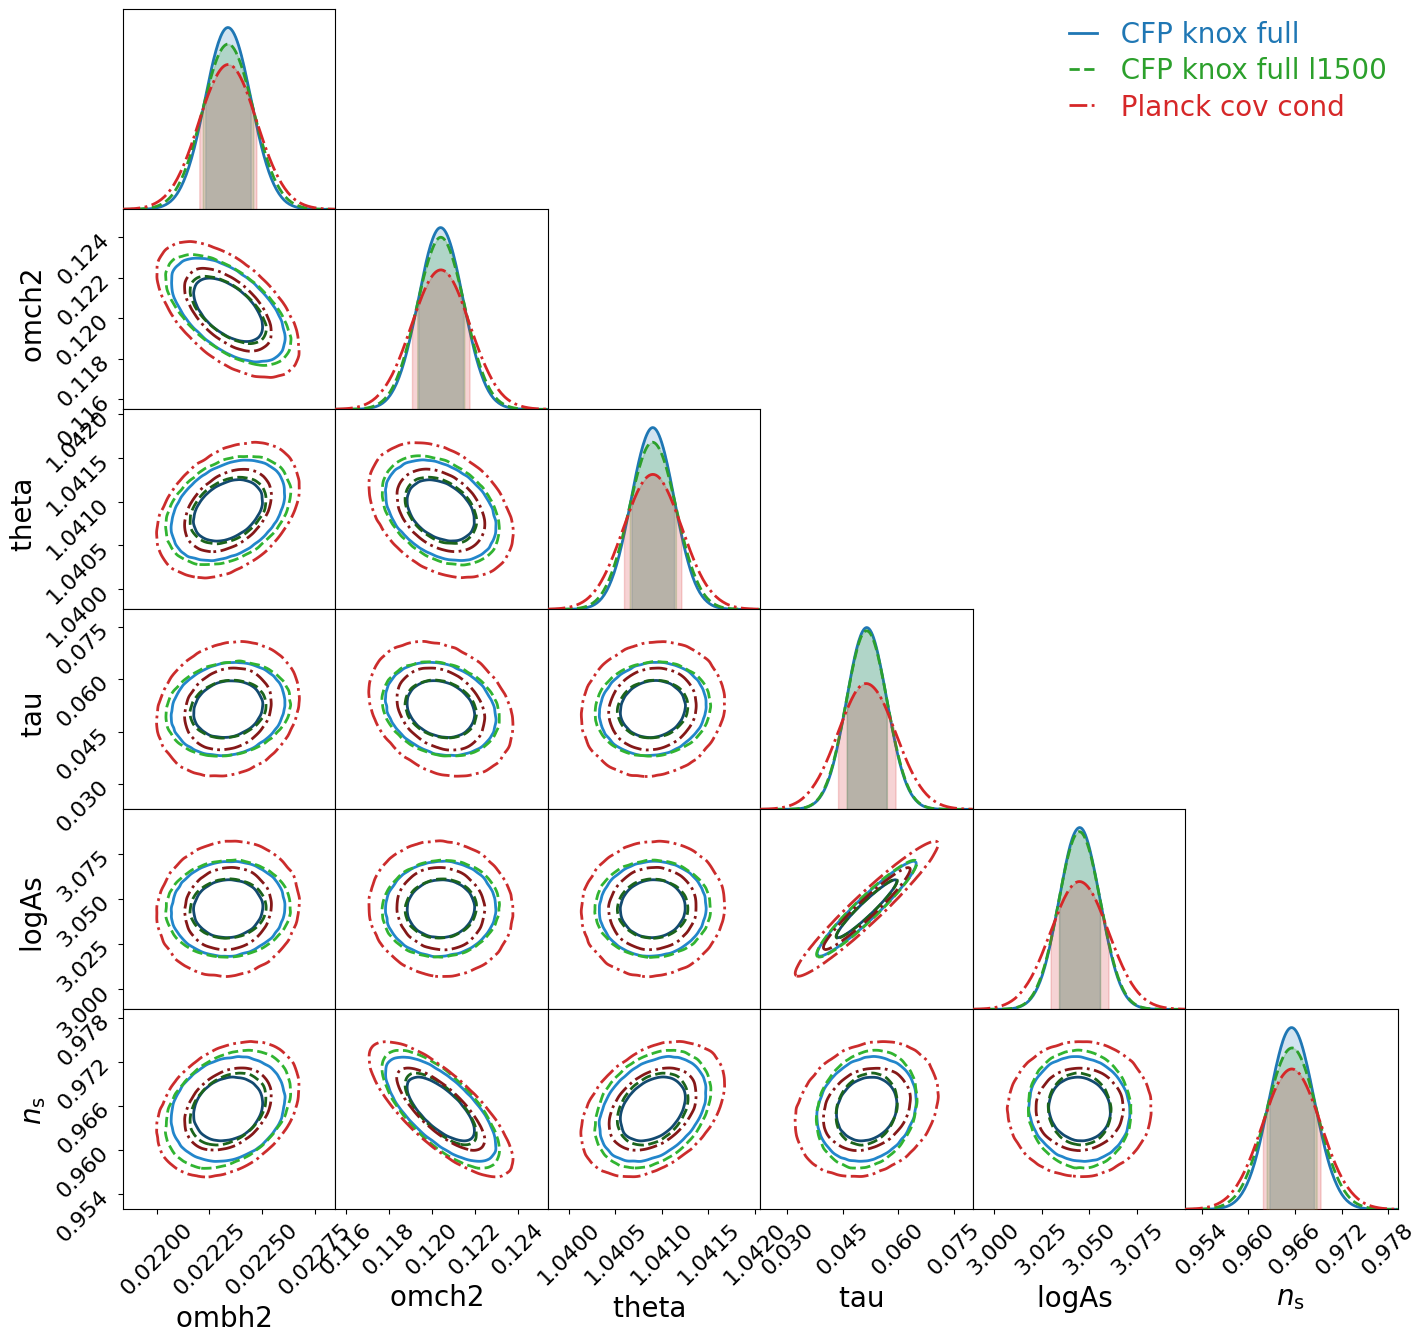

In [20]:
triangle_path = repo_root / "tmp/planck_bestfit_theta_knox_full/covmat_compare/triangle_legacy_knox_3part_covmarg_covcond.png"
triangle_path.parent.mkdir(parents=True, exist_ok=True)

fco.make_triangle_plot(
    #fishers=[f_legacy, f_knox_full, f_knox_3part, f_cov_marg, f_cov_cond],
    fishers=[f_knox_full, f_knox_full_l1500, f_cov_cond],
    #fisher_labels=["CFP legacy", "CFP knox full", "CFP knox 3-part", "Planck cov marg", "Planck cov cond"],
    fisher_labels=["CFP knox full", "CFP knox full l1500", "Planck cov cond"],
    params=params,
    #colors=["#7f7f7f", "#1f77b4", "#2ca02c", "#d62728", "#9467bd"],
    colors=["#1f77b4", "#2ca02c", "#d62728", "#9467bd"],
    shade_fisher=False,
    ls_fisher=["-", "--", "-.", ":", "-."],
    lw_fisher=[2.0, 2.0, 2.0, 2.0, 2.0],
    savefile=str(triangle_path),
)

print("Saved:", triangle_path)

## High/Low Information Split (Diagonal Fisher Entries)

,parameter,diag_high,diag_low_t,diag_low_e,diag_total,frac_high,frac_low_t,frac_low_e
0,ombh2,1.511264e+08,4593.645645,22864.930648,1.511538e+08,0.999818,0.000030,0.000151
1,omch2,5.788111e+06,1664.376639,567.230956,5.790343e+06,0.999615,0.000287,0.000098
2,theta,2.669292e+07,402.992243,63.757417,2.669339e+07,0.999983,0.000015,0.000002
3,tau,4.447527e+06,749.214779,26993.974265,4.475270e+06,0.993801,0.000167,0.006032
4,logAs,1.120571e+06,313.764477,13.007907,1.120898e+06,0.999708,0.000280,0.000012
5,ns,5.707712e+05,2851.868690,262.156139,5.738853e+05,0.994574,0.004969,0.000457


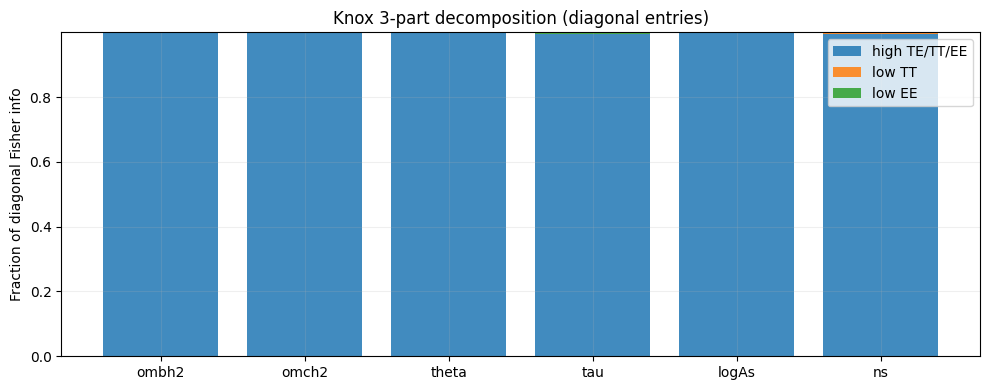

In [21]:
F_high = np.asarray(f_knox_high.get_fisher_matrix(), dtype=float)
F_low_t = np.asarray(f_knox_low_t.get_fisher_matrix(), dtype=float)
F_low_e = np.asarray(f_knox_low_e.get_fisher_matrix(), dtype=float)
F_tot = np.asarray(f_knox_3part.get_fisher_matrix(), dtype=float)

idx = {p: f_knox_3part.get_param_index(p) for p in params}
diag_rows = []
for p in params:
    i = idx[p]
    d_h = float(F_high[i, i])
    d_t = float(F_low_t[i, i])
    d_e = float(F_low_e[i, i])
    d_tot = float(F_tot[i, i])
    diag_rows.append(
        {
            "parameter": p,
            "diag_high": d_h,
            "diag_low_t": d_t,
            "diag_low_e": d_e,
            "diag_total": d_tot,
            "frac_high": d_h / d_tot if d_tot != 0 else np.nan,
            "frac_low_t": d_t / d_tot if d_tot != 0 else np.nan,
            "frac_low_e": d_e / d_tot if d_tot != 0 else np.nan,
        }
    )

df_diag = pd.DataFrame(diag_rows)
display(df_diag)

x = np.arange(len(params))
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x, df_diag["frac_high"], label="high TE/TT/EE", alpha=0.85)
ax.bar(x, df_diag["frac_low_t"], bottom=df_diag["frac_high"], label="low TT", alpha=0.85)
ax.bar(
    x,
    df_diag["frac_low_e"],
    bottom=df_diag["frac_high"] + df_diag["frac_low_t"],
    label="low EE",
    alpha=0.85,
)
ax.set_xticks(x)
ax.set_xticklabels(params)
ax.set_ylabel("Fraction of diagonal Fisher info")
ax.set_title("Knox 3-part decomposition (diagonal entries)")
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()